Provided example uses toy data. You can access the real [UK travel survey from 2002-2021](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) from the [UK Data Service](https://beta.ukdataservice.ac.uk).

In [1]:
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt

from ntsx import core, ops
from ntsx import read_nts
from ntsx.plot import plot
from ntsx.encoders.graph_encoder import GraphEncoder
from ntsx.encoders.table_encoder import TableTokeniser

In [2]:
# load dummy data (synthesised from UK NTS)

dir = Path("data/dummyNTS/")
trips_path = dir / "trips.tab"
attributes_path = dir / "individuals.tab"
hhs_path = dir / "households.tab"

years = [2021]

write_dir = Path("tmp")
write_dir.mkdir(exist_ok=True)

In [3]:
trips, labels = read_nts.load_nts(trips_path, attributes_path, hhs_path, years=years)
trips.head(10)

HIDs in people and households do not match, attempting to fix...
Fixed: People 6 -> 7, HHs 5 -> 5


,tid,year,day,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,did,pid
0,1,2021,2,1,1,1,car,home,social,0.989618,675,683,7,7,0,1_1
1,2,2021,2,1,1,2,car,social,other,1.002945,720,735,7,7,0,1_1
2,3,2021,2,1,1,3,car,other,social,0.989618,770,780,7,7,0,1_1
3,4,2021,2,1,1,4,taxi,social,home,0.989618,1110,1130,7,7,0,1_1
4,5,2021,3,1,1,1,car,home,social,0.999891,760,770,7,7,1,1_1
5,6,2021,3,1,1,2,car,social,social,0.999891,790,805,7,7,1,1_1
6,7,2021,3,1,1,3,car,social,other,1.061665,810,825,7,7,1,1_1
7,8,2021,3,1,1,4,car,other,other,1.061665,845,852,7,7,1,1_1
8,9,2021,3,1,1,5,car,other,social,0.999891,865,873,7,7,1,1_1
9,10,2021,3,1,1,6,car,social,escort,1.006313,908,914,7,7,1,1_1


In [4]:
read_nts.label_mapping(labels).head()

,hid,age,gender,ethnicity,education,license,car_access,work_status,year,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles
iid,,,,,,,,,,,,,,,,,
1,2002003369,70+,F,white,unknown,yes,yes,unemployed,2021,suburban,1,1,1adult,2,1,1,0
2,2002003370,50-70,F,white,unknown,no,no,employed,2021,suburban,1,2,1adult,2,1,1,1
3,2002003371,70+,F,white,unknown,no,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
4,2002003371,70+,M,white,unknown,yes,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
5,2002003372,40-50,M,white,unknown,yes,yes,employed,2021,suburban,1,1,1adult,2,1,1,0


In [5]:
# encode labels
label_encoder = TableTokeniser(labels)
labels_encoded = label_encoder.encode(labels)
labels_encoded[0:10]

<ntsx.encoders.table_encoder.TableTokeniser object at 0x7c5eb1348830> configured with columns: ['age', 'gender', 'ethnicity', 'education', 'license', 'car_access', 'work_status', 'year', 'area', 'income', 'hh_size', 'hh_composition', 'hh_children', 'hh_cars', 'hh_bikes', 'hh_motorcycles']
            embed_types: ['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical']
            embed_sizes: [5, 2, 1, 1, 2, 4, 3, 1, 2, 1, 2, 1, 1, 1, 1, 3]
            maps: [{14: 0, 15: 1, 18: 2, 19: 3, 20: 4}, {1: 0, 2: 1}, {1: 0}, {0: 0}, {1: 0, 3: 1}, {2: 0, 3: 1, 4: 2, 6: 3}, {1: 0, 2: 1, 4: 2}, {2021: 0}, {1: 0, 3: 1}, {1: 0}, {1: 0, 2: 1}, {1: 0}, {2: 0}, {1: 0}, {1: 0}, {0: 0, 1: 1, 2: 2}]
            dtypes: [dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('i

tensor([[4, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [2, 1, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2],
        [3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
# initiate encoders for trip features
trip_encoder = GraphEncoder(trips)  # currently needs to be initialised from trips table

# can be used to encode trips table
trips_encoded = trip_encoder.encode_trips_table(trips)
display(trips_encoded.head())

CategoricalEncoder(mode):
            size: 5
            categories: {'bus': 0, 'car': 1, 'taxi': 2, 'train': 3, 'walk': 4}
            
CategoricalEncoder(oact):
            size: 9
            categories: {'education': 0, 'escort': 1, 'home': 2, 'hotel': 3, 'medical': 4, 'other': 5, 'shop': 6, 'social': 7, 'work': 8}
            
CategoricalEncoder(dact):
            size: 9
            categories: {'education': 0, 'escort': 1, 'home': 2, 'hotel': 3, 'medical': 4, 'other': 5, 'shop': 6, 'social': 7, 'work': 8}
            
CategoricalEncoder(day):
            size: 39
            categories: {2: 0, 3: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 16: 12, 17: 13, 19: 14, 20: 15, 21: 16, 23: 17, 24: 18, 26: 19, 27: 20, 28: 21, 29: 22, 30: 23, 33: 24, 35: 25, 36: 26, 37: 27, 38: 28, 39: 29, 40: 30, 41: 31, 42: 32, 43: 33, 44: 34, 45: 35, 46: 36, 47: 37, 49: 38}
            
>>> Warning: CategoricalEncoder has more than 20 categories (39)). <<<
TimeEncoder(tst):


,tid,year,day,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,did,pid
0,1,2021,0,1,1,1,1,2,7,0.989618,0.468750,0.474306,0,0,0,1_1
1,2,2021,0,1,1,2,1,7,5,1.002945,0.500000,0.510417,0,0,0,1_1
2,3,2021,0,1,1,3,1,5,7,0.989618,0.534722,0.541667,0,0,0,1_1
3,4,2021,0,1,1,4,2,7,2,0.989618,0.770833,0.784722,0,0,0,1_1
4,5,2021,1,1,1,1,1,2,7,0.999891,0.527778,0.534722,0,0,1,1_1


In [7]:
# or for individual features
display((trip_encoder.encode("bus", "mode"), trip_encoder.encode(1220, "tst")))

# decoding...
display((trip_encoder.decode(2, "mode"), trip_encoder.decode(0.5, "tst")))

# for iterables more generally (as we might have in a graph)
display(
    (
        trip_encoder.encode_iterable([1220, 1221], "tst"),
        trip_encoder.decode_iterable([0.5, 0.6], "tst"),
    )
)

(0, 0.8472222222222222)

('taxi', 720)

(0    0.847222
 1    0.847917
 dtype: float64,
 0    720
 1    864
 dtype: int64)

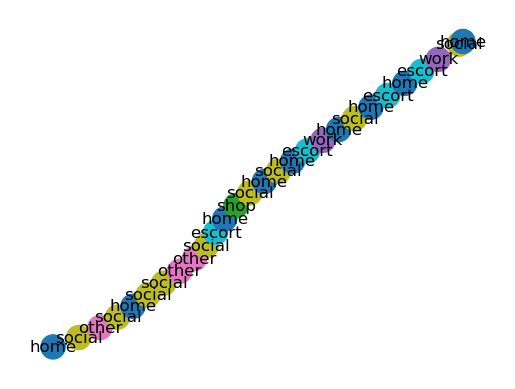

In [8]:
# load  the first persons trips into nx
iid = 1
g = core.to_nx(trips.loc[trips.iid == iid])
plot(g)

Could not find any 0 activities.
Could not find any 2 activities.
Could not find any 8 activities.


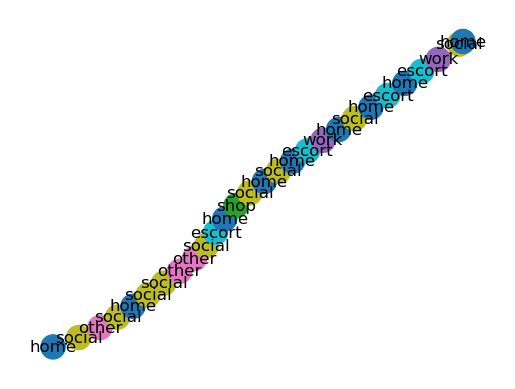

In [9]:
# nodes/vertices represent facilities for activities (they have a type eg "work" and an approx location)
# edges represent trips between activities (they have a mode eg "car", a start time and a duration)
# first we combine facilities (nodes) based on a given list of "anchor" activities

g_anchored = ops.anchor_activities(g, [0, 2, 8])
plot(g_anchored)

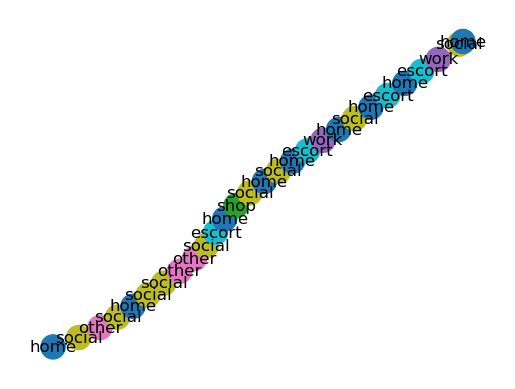

In [10]:
# now we merge similar looking facilities beyond the anchors
# we do this by iteratively searching facilities breadth first from the home facility
# for each facility we condider all pairs of trips (in and out)
# if the trips are similar and come from similar looking facilities we merge the facilities
# Facility similarity is based on a facility having the same activity typpe and zone
# Trip similarity is based on the trip mode being the same and the duration being similar

merged_g = ops.merge_similar(g_anchored, duration_tolerance=0.2, verbose=True)
plot(merged_g)

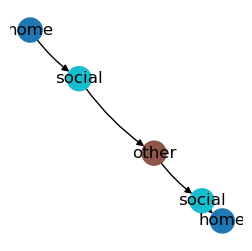

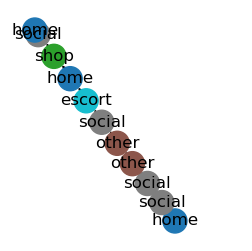

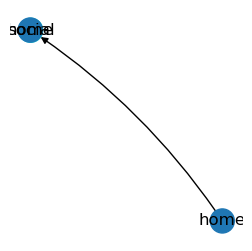

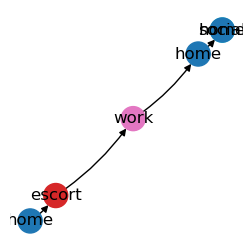

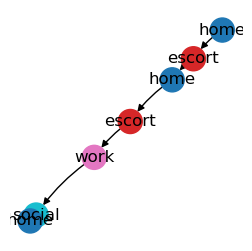

In [11]:
# We can split the graph back into days:
for day, g in ops.iter_days(merged_g):
    plot(g, figsize=(3, 3))

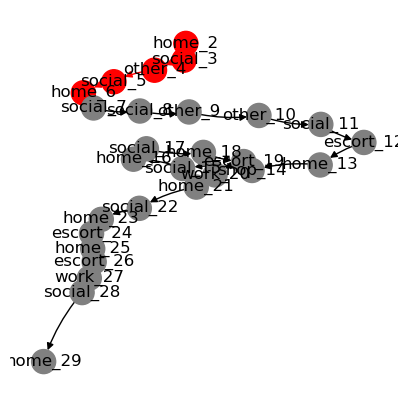

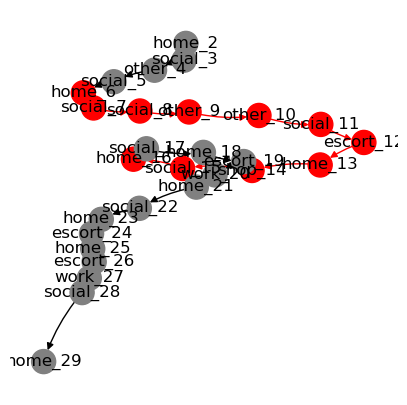

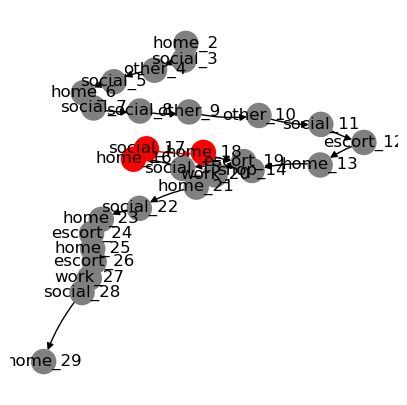

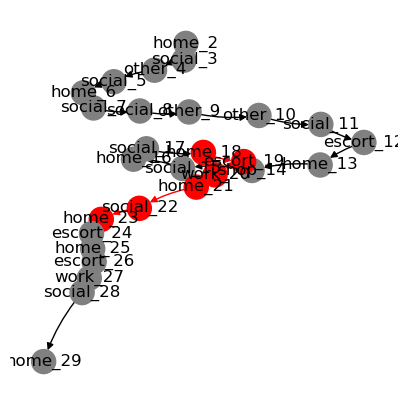

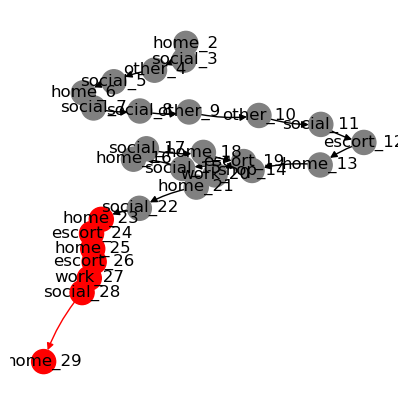

In [12]:
# we can also create a boolean mask for edges
# in this case we demo a mask for each day

positions = nx.spring_layout(merged_g, weight="duration", seed=12345)
acts = {i: f"{node.get("act")}_{i}" for i, node in merged_g.nodes(data=True)}

for day, g in ops.iter_days_masked(merged_g):
    masked_edges = [
        (u, v, k) for u, v, k in g.edges(keys=True) if g[u][v][k].get("masked")
    ]
    masked_nodes = set([u for u, _, _ in masked_edges]) | set(
        [v for _, v, _ in masked_edges]
    )
    edge_colors = [
        "red" if g[u][v][k].get("masked") else "black" for u, v, k in g.edges(keys=True)
    ]
    node_colors = ["red" if n in masked_nodes else "grey" for n in g.nodes]

    fig, ax = plt.subplots(figsize=(5, 5))
    nx.draw(
        g,
        positions,
        labels=acts,
        with_labels=True,
        connectionstyle="arc3,rad=0.1",
        ax=ax,
        edge_color=edge_colors,
        node_color=node_colors,
    )

Could not find any 0 activities.
Could not find any 2 activities.
Could not find any 8 activities.


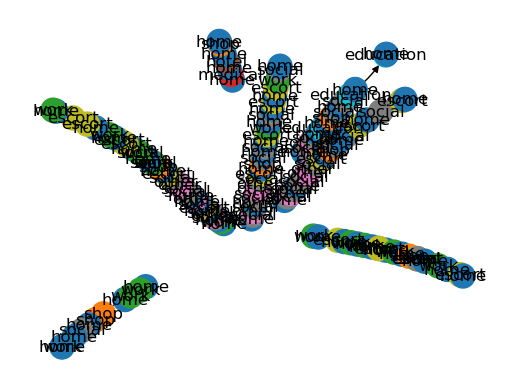

In [13]:
# we can repeat above for multiple persons
# load in first 1000 trips and combine them into a single graph

gs = core.to_nx(trips.head(1000))
gs = ops.anchor_activities(gs, [0, 2, 8])
gs = ops.merge_similar(gs, duration_tolerance=0.2)
plot(gs)

/home/fred/Projects/ntsx/ntsx/plot.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


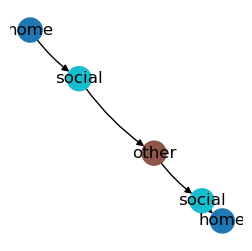

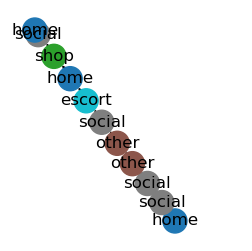

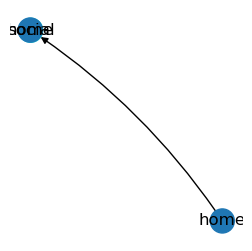

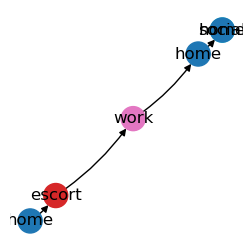

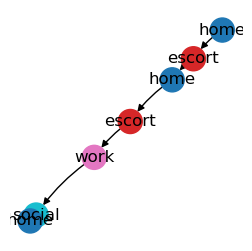

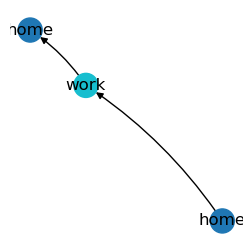

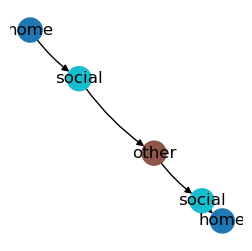

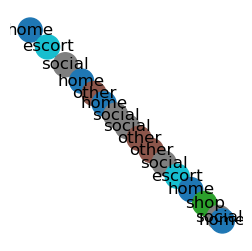

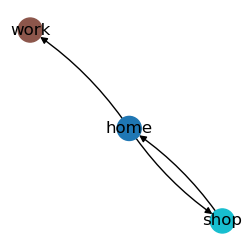

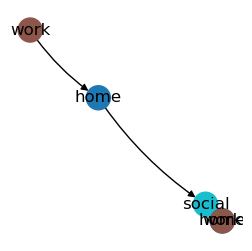

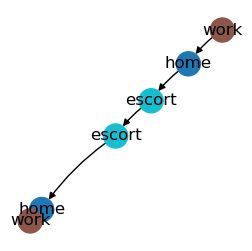

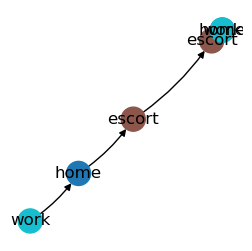

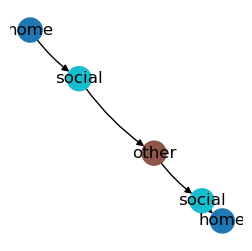

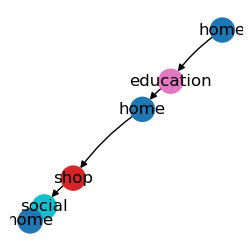

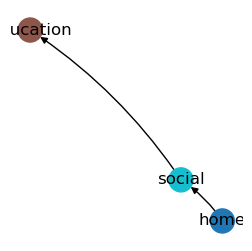

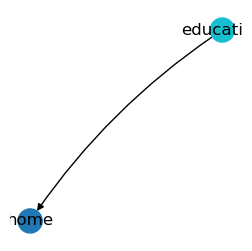

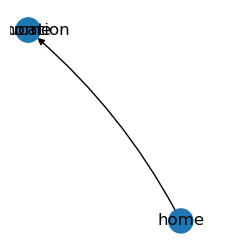

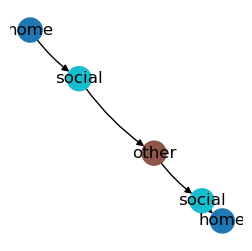

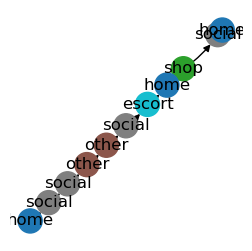

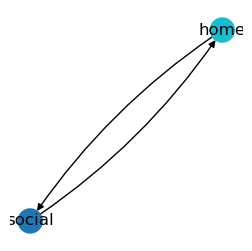

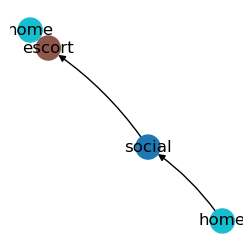

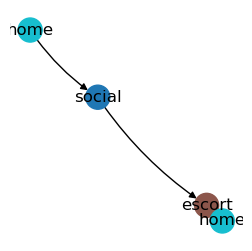

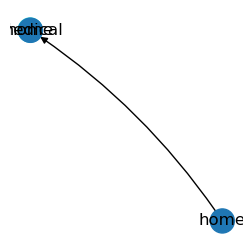

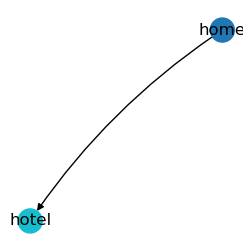

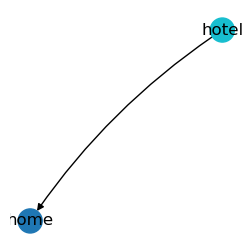

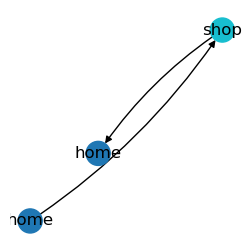

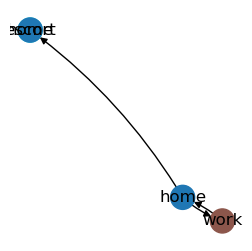

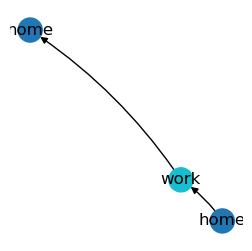

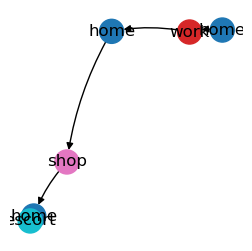

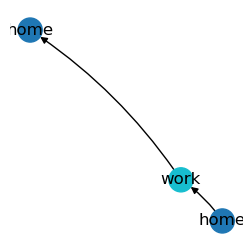

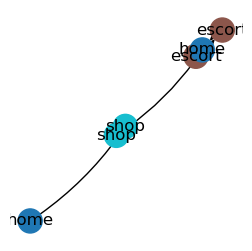

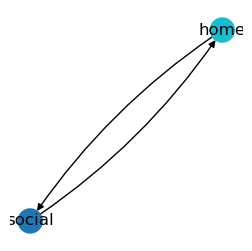

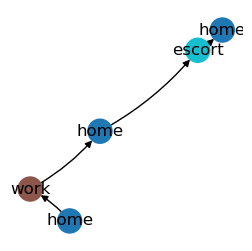

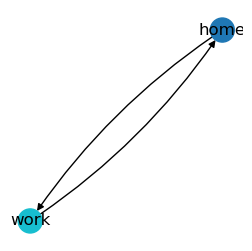

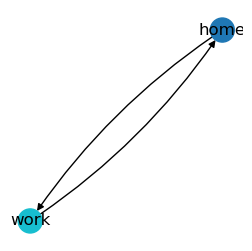

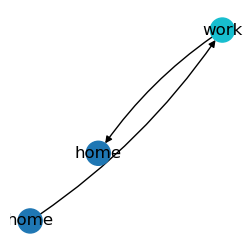

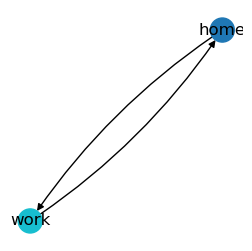

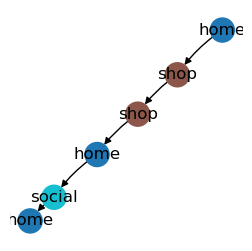

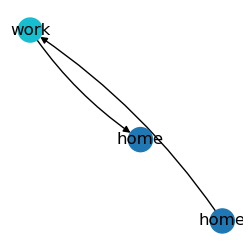

In [14]:
for day, g in ops.iter_days(gs):
    plot(g, figsize=(3, 3))